<div align="right">
Massimo Nocentini<br>
<br>April 28, 2016: counting sort
<br>April 26, 2016: hidden squares, Bunch pattern
</div>
<br>
<div align="center">
<b>Abstract</b><br>
This document collect some gotchas and experiment in Python, to understand objects and execution pitfalls.
</div>

# Some gotchas

The following notebook collect some cell to understand -- the hard way -- little, but *subtle*, concepts.

The main reference from which they are taken is the book by [Magnus Lie Hetland][hetland], in pure [Python][py].

[hetland]:http://hetland.org/writing/python-algorithms/
[py]:http://www.python.org

In [25]:
from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

## A grouping pattern, avoiding *quadratic* time

Assume to have two lists that have to be related in some way, namely using a predicate $P$. In the following example we want to build a list of all pairs (boy,girl) such that their names starts with the same letter. Here the input:

In [2]:
girls = ['alice', 'allie', 'bernice', 'brenda', 'clarice', 'cilly']
boys = ['chris', 'christopher', 'arald', 'arnold', 'bob']

the bad way, quadratic time:

In [5]:
[(b, g) for b in boys for g in girls if b[0] == g[0]]

[('chris', 'clarice'),
 ('chris', 'cilly'),
 ('christopher', 'clarice'),
 ('christopher', 'cilly'),
 ('arald', 'alice'),
 ('arald', 'allie'),
 ('arnold', 'alice'),
 ('arnold', 'allie'),
 ('bob', 'bernice'),
 ('bob', 'brenda')]

there is a better approach avoiding quadratic time, toward [`defaultdict`][dd]:

[dd]:https://docs.python.org/3/library/collections.html#defaultdict-objects

In [7]:
letterGirls = {}
for girl in girls:
    letterGirls.setdefault(girl[0], []).append(girl)

[(b, g) for b in boys for g in letterGirls[b[0]]]

[('chris', 'clarice'),
 ('chris', 'cilly'),
 ('christopher', 'clarice'),
 ('christopher', 'cilly'),
 ('arald', 'alice'),
 ('arald', 'allie'),
 ('arnold', 'alice'),
 ('arnold', 'allie'),
 ('bob', 'bernice'),
 ('bob', 'brenda')]

However there is an even better solution, as pointed out in the [example][e] subsection of the previous link: use `defaultdict` instead of repeating call `setdefault` method for each new key. From the official documentation:

[e]:https://docs.python.org/3/library/collections.html#defaultdict-examples

In [10]:
>>> s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
>>> d = defaultdict(list)
>>> for k, v in s:
...     d[k].append(v)
...
>>> list(d.items())
[('blue', [2, 4]), ('red', [1]), ('yellow', [1, 3])]

[('blue', [2, 4]), ('red', [1]), ('yellow', [1, 3])]

## The *Bunch* pattern

Hetland, pag. 34, propose the following pattern to build a container of properties in order to avoid vanilla dict (adjusting from item 4.18 of Alex Martelli's [*Python Cookbook*][cb]):

[cb]:http://shop.oreilly.com/product/9780596007973.do

In [12]:
class Bunch(dict):
    def __init__(self, *args, **kwds):
        super(Bunch, self).__init__(*args, **kwds)
        self.__dict__ = self

In [15]:
>>> T = Bunch
>>> t = T(left=T(left="a", right="b"), right=T(left="c"))
>>> t.left

{'left': 'a', 'right': 'b'}

In [16]:
>>> t.left.right

'b'

In [17]:
>>> t['left']['right']

'b'

In [18]:
>>> "left" in t.right

True

In [19]:
"right" in t.right

False

However inheriting from `dict` is discouraged by Alex:

>A further tempting but not fully sound alternative is to have the Bunch class inherit
from `dict`, and set attribute access special methods equal to the item access special
methods, as follows:

    class DictBunch(dict):
        __getattr__ = dict.__getitem__
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__

>One problem with this approach is that, with this definition, an instance x of
`DictBunch` has many attributes it doesn't really have, because it inherits all the
attributes (methods, actually, but there's no significant difference in this context) of
`dict`. So, you can’t meaningfully check `hasattr(x, someattr)` , as you could with the
classes `Bunch` and `EvenSimplerBunch` (which sets the dictionary directly, without using `update`) 
previously shown, unless you can somehow rule
out the value of someattr being any of several common words such as `keys` , `pop` ,
and `get`. Python’s distinction between attributes and items is really a wellspring of clarity and
simplicity. Unfortunately, many newcomers to Python wrongly believe that it would
be better to confuse items with attributes, generally because of previous experience
with JavaScript and other such languages, in which attributes and items are regularly
confused. But educating newcomers is a much better idea than promoting item/
attribute confusion.

Alex original definition reads as follows:

In [21]:
class Bunch(object):
    def __init__(self, **kwds):
        self.__dict__.update(kwds)

It is interesting to observe that this idiom has been merged within the *standard library*, starting from Python **3.3**, as with the name of [`SimpleNamespace`][sn]:

[sn]:https://docs.python.org/3/library/types.html#types.SimpleNamespace

In [22]:
from types import SimpleNamespace

x, y = 32, 64
point = SimpleNamespace(datum=y, squared=y*y, coord=x)
point

namespace(coord=32, datum=64, squared=4096)

In [23]:
point.datum, point.squared, point.coord

(64, 4096, 32)

In [24]:
[i for i in point]

TypeError: 'types.SimpleNamespace' object is not iterable

If you need `point` to be iterable use the structured object [`namedtuple`][nt] instead.

[nt]:https://docs.python.org/3/library/collections.html#collections.namedtuple

## Python's `list.append` isn't Lisp's `cons`

Python `list` objects behave like `stack` objects, such that it is *cheap* to `append` and `pop` at the *top*, which is the *right* end. On the other hand, Lisp `pair` objects allows us to *easily* `cons` on the *beginning*, the very *opposite* direction.

In [37]:
def fast_countdown(count):
    nums = []
    for i in range(count):
        nums.append(i)
    nums.reverse()
    return nums

def slow_countdown(count):
    nums = []
    for i in range(count):
        nums.insert(0, i)
    return nums

def printer(lst, chunk=10):
    print("{}...{}".format(" ".join(map(str, lst[:chunk])),
                           " ".join(map(str, lst[-chunk:]))))

In [38]:
%timeit nums = fast_countdown(10**5)
printer(nums)

100 loops, best of 3: 7.84 ms per loop
99999 99998 99997 99996 99995 99994 99993 99992 99991 99990...9 8 7 6 5 4 3 2 1 0


In [39]:
%timeit nums = slow_countdown(10**5)
printer(nums)

1 loop, best of 3: 2.86 s per loop
99999 99998 99997 99996 99995 99994 99993 99992 99991 99990...9 8 7 6 5 4 3 2 1 0


Citing Hetland, pag 11:

> Python lists aren’t really lists in the traditional computer science sense of the word, and that explains the puzzle of why append is so much more efficient than insert . A classical list - a so-called linked list - is implemented as a series of nodes, each (except for the last) keeping a reference to the next. 
The underlying implementation of Python’s list type is a bit different. Instead of several separate nodes
referencing each other, a list is basically a single, contiguous slab of memory - what is usually known as an
array. This leads to some important differences from linked lists. For example, while iterating over the contents
of the list is equally efficient for both kinds (except for some overhead in the linked list), directly accessing an element at a given index is much more efficient in an array. This is because the position of the element can be
calculated, and the right memory location can be accessed directly. In a linked list, however, one would have to
traverse the list from the beginning.
The difference we've been bumping up against, though, has to do with insertion. In a linked list, once you know
where you want to insert something, insertion is cheap; it takes roughly the same amount of time, no matter how
many elements the list contains. That's not the case with arrays: An insertion would have to move all elements
that are to the right of the insertion point, possibly even moving all the elements to a larger array, if needed.
A specific solution for appending is to use what’s often called a dynamic array, or vector. 4 The idea is to allocate an array that is too big and then to reallocate it in linear time whenever it overflows. It might seem that this makes the append just as bad as the insert. In both cases, we risk having to move a large number of elements.
The main difference is that it happens less often with the append. In fact, if we can ensure that we always move
to an array that is bigger than the last by a fixed percentage (say 20 percent or even 100 percent), the average
cost, amortized over many appends, is constant.

### enhance with `deque` objects

`deque` implements *FIFO* queues: they are as cheap to append to the right as a normal `list`, but enhance it to *cheaply* insert on the *front* too:

In [1]:
from collections import deque

def enhanced_slow_countdown(count):
    nums = deque()
    for i in range(count):
        nums.appendleft(i)
    return nums

In [41]:
%timeit nums = enhanced_slow_countdown(10**5)
printer(nums)

100 loops, best of 3: 8.22 ms per loop
99999 99998 99997 99996 99995 99994 99993 99992 99991 99990...9 8 7 6 5 4 3 2 1 0


## Hidden squares

### concerning `list`s and `set`s

In [2]:
from random import randrange

max_value = 10000
checks = 1000
L = [randrange(max_value) for i in range(checks)]

In [43]:
%timeit [randrange(max_value) in L for _ in range(checks)]

10 loops, best of 3: 18 ms per loop


In [44]:
S = set(L)

%timeit [randrange(max_value) in S for _ in range(checks)]

1000 loops, best of 3: 1.11 ms per loop


Hetland's words, pag. 35:

>They're both pretty fast, and it might seem pointless to create a set from the list—unnecessary work, right? Well,
it depends. If you're going to do many membership checks, it might pay off, because membership checks are linear
for lists and constant for sets. What if, for example, you were to gradually add values to a collection and for each step check whether the value was already added? [...] Using a list would give you quadratic running time, whereas using a set would be linear. That’s a huge difference. **The lesson is that it's important to pick the right built-in data structure for the job.**

In [67]:
lists = [[1, 2], [3, 4, 5], [6]]
sum(lists, [])

[1, 2, 3, 4, 5, 6]

Hetland, pag.36:

>This works, and it even looks rather elegant, but it really isn't. You see, under the covers, the sum function doesn't know all too much about what you’re summing, and it has to do one addition after another. That way, you're right back at the quadratic running time of the += example for strings. Here's a better way: Just try timing both versions. As long as lists is pretty short, there won't be much difference, but it shouldn't
take long before the sum version is thoroughly beaten.

In [69]:
res = []
for lst in lists:
    res.extend(lst)
res

[1, 2, 3, 4, 5, 6]

### concerning `string`s

In [63]:
def string_producer(length=10**7):
    return ''.join([chr(randrange(ord('a'), ord('z'))) for _ in range(length)])

In [64]:
%%timeit # %% means 'cell-wise'

s = ""
for chunk in string_producer():
    s += chunk

1 loop, best of 3: 14.9 s per loop


maybe some optimization is performed because `s` is a `string` object.

In [65]:
%%timeit

chunks = []
for chunk in string_producer():
    chunks.append(chunk)
s = ''.join(chunks)

1 loop, best of 3: 14.7 s per loop


a better approach using constant `append` to the top

In [66]:
%timeit s = ''.join(string_producer())

1 loop, best of 3: 14.2 s per loop


maybe a little better since it doesn't loop with `for` explicitly.

# Counting

## Max permutation

The following function `max_perm` computes the maximum permutation that can be applied given a desired one; namely,
it produces a new permutation that moves as many elements as it can, in order to ensure the `one-to-one` property. It can be seen as a function that *fixes* a given permutation according to the required behavior.

In [11]:
def perm_isomorphism(M, domain):
    iso = dict(enumerate(domain))
    return [iso[M[i]] for i in range(len(M))]

def fix_perm(M, fix):
    return [M[i] if i in fix else i for i in range(len(M))]

The following is a naive implementation, recursive but in $\mathcal{O}(n^{2})$, where $n$ is the permutation length.

In [12]:
def naive_max_perm(M, A=None):
    '''
    Fix a permutation such that it is one-to-one and maximal, recursively.
    
    consumes:
    M - a permutation as a list of integers
    A - a set of positions allowed to move
    
    produces:
    a set `fix` such that makes M maximal, ensuring to be one-to-one
    '''
    if A is None: A = set(range(len(M))) # init to handle first invocation, all elems can move
    
    if len(A) is 1: return A # recursion base, unary perm can move, trivial
    
    B = set(M[i] for i in A) # b in B iff b is desired by someone
    C = A - B # c in C iff c isn't desired, so discard it
    return naive_max_perm(M, A - C) if C else A # recur with desired position only

In [7]:
identity = range(8)
letters = "abcdefgh"
perm_isomorphism(identity, letters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [8]:
M = [2, 2, 0, 5, 3, 4, 7, 4]
perm_isomorphism(M, letters)

['c', 'c', 'a', 'f', 'd', 'e', 'h', 'e']

In [13]:
fix = naive_max_perm(M)
max_M = fix_perm(M, fix)
perm_isomorphism(max_M, letters)

['c', 'b', 'a', 'f', 'd', 'e', 'g', 'h']

Hetland, pag. 78:

>The function naive_max_perm receives a set `A` of remaining people and creates a set `B` of seats that are pointed
to. If it finds an element in `A` that is not in `B`, it removes the element and solves the remaining problem recursively. Let's use the implementation on our example, M = `[2, 2, 0, 5, 3, 5, 7, 4]`:
 
    naive_max_perm(M)
    {0, 2, 5}
 
>So, a, c, and f can take part in the permutation. The others will have to sit in nonfavorite seats.
The implementation isn't too bad. The handy set type lets us manipulate sets with ready-made high-level operations,
rather than having to implement them ourselves. There are some problems, though. For one thing, we might want an
iterative solution. [...] A worse problem, though, is that the algorithm is quadratic! (Exercise 4-10 asks you to show this.) The most wasteful operation is the repeated creation of the set B. If we could just keep track of which chairs are no longer pointed to, we could eliminate this operation entirely. One way of doing this would be to keep a count for each element. We could decrement the count for chair x when a person pointing to x is eliminated, and if x ever got a count of zero, both person and chair x would be out of the game.
>>This idea of reference counting can be useful in general. It is, for example, a basic component in many systems
for garbage collection (a form of memory management that automatically deallocates objects that are no longer useful). You'll see this technique again in the discussion of topological sorting.

>There may be more than one element to be eliminated at any one time, but we can just put any new ones we
come across into a “to-do” list and deal with them later. If we needed to make sure the elements were eliminated in
the order in which we discover that they’re no longer useful, we would need to use a first-in, first-out queue such as the deque class (discussed in Chapter 5). We don’t really care, so we could use a set, for example, but just appending to and popping from a list will probably give us quite a bit less overhead. But feel free to experiment, of course.

In [14]:
def max_perm(M):
    n = len(M) # How many elements?
    A = set(range(n)) # A = {0, 1, ... , n-1}
    count = Counter(M) # desired positions by frequencies
    Q = deque([i for i in A if not count[i]]) # useless elements
    while Q: # While useless elts. left...
        i = Q.pop() # get one of them
        A.remove(i) # remove it from the maximal permutation
        j = M[i] # get its desired position
        count[j] -= 1 # and release it for someone else
        if not count[j]: # if such position isn't desired anymore
            Q.appendleft(j) # enqueue such position in order to discard it            
    return A

In [15]:
fix = max_perm(M)
max_M = fix_perm(M, fix)
perm_isomorphism(max_M, letters)

['c', 'b', 'a', 'f', 'd', 'e', 'g', 'h']

## Counting Sort

Hetland, pag 85:

>By default, I'm just sorting objects based on their values. By supplying a key function, you can sort by
anything you’d like. Note that the keys must be integers in a limited range. If this range is $0\ldots k-1$, running time is then $\mathcal{O}(n + k)$. (Note that although the common implementation simply counts the elements and then figures out where to put them in `B`, Python makes it easy to just build value lists for each key and then
concatenate them.) If several values have the same key, they'll end up in the original order with respect to
each other. Sorting algorithms with this property are called *stable*.

In [55]:
def counting_sort(A, key=None, sort_boundary=None):
    '''
    Sorts the given collection A in linear time, assuming their elements are hashable.
    
    This implementation implements a vanilla counting sort, working in linear time respect
    iterable length and spacing between objects. It works best if elements are evenly, namely
    *uniformly* distributed in the domain; on contrast, if they are sparse and concentrated 
    next accumulation points, traversing distances between them is time consuming. 
    If `sort_boundary` is instantiated to a float within [0,1], then the domain is ordered
    using a classic loglinear algorithm before building the result.
    '''
    if key is None: key = lambda x: x
        
    B, C = [], defaultdict(list)
    for x in A:
        C[key(x)].append(x)
    
    domain = sorted(C) if sort_boundary and len(C) <= len(A)*sort_boundary else range(min(C), max(C)+1)
    for k in domain:
        B.extend(C[k])
        
    return B

In [62]:
A = [randrange(50) for i in range(2*10**3)]

In [63]:
assert sorted(A) == counting_sort(A)

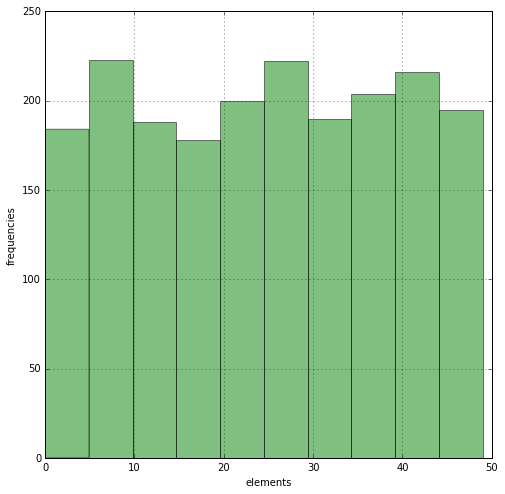

In [81]:
n, bins, patches = plt.hist(A, 10, normed=0,facecolor='green', alpha=0.5)
plt.xlabel('elements')
plt.ylabel('frequencies')
plt.grid(True)
plt.show()

In [82]:
%timeit counting_sort(A)

1000 loops, best of 3: 428 µs per loop


In [83]:
%timeit counting_sort(A, sort_boundary=1)

1000 loops, best of 3: 429 µs per loop


In [99]:
B = [randrange(50) for i in range(10**3)] + [10**4 + randrange(50) for i in range(10**3)]

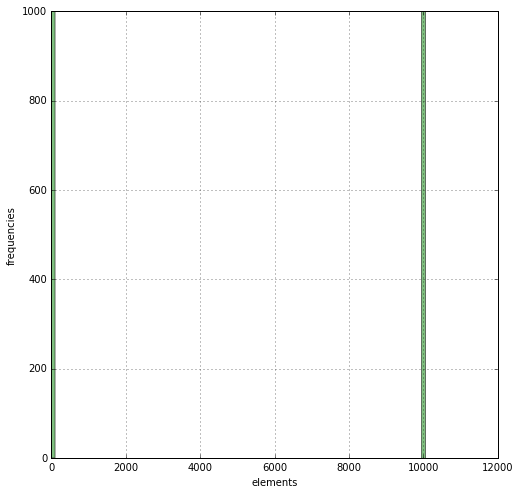

In [103]:
n, bins, patches = plt.hist(B, 100, normed=0,facecolor='green', alpha=0.5)
plt.xlabel('elements')
plt.ylabel('frequencies')
plt.grid(True)
plt.show()

In [104]:
assert sorted(B) == counting_sort(B)

In [105]:
%timeit counting_sort(B)

100 loops, best of 3: 3.53 ms per loop


In [106]:
%timeit counting_sort(B, sort_boundary=1/8)

1000 loops, best of 3: 470 µs per loop


---
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Gotchas tutorial</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="mailto:massimo.nocentini@unifi.it" property="cc:attributionName" rel="cc:attributionURL">Massimo Nocentini</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/massimo-nocentini/competitive-programming/blob/master/tutorials/gotchas.ipynb" rel="dct:source">https://github.com/massimo-nocentini/competitive-programming/blob/master/tutorials/gotchas.ipynb</a>.